#Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/your_path'

# Stratified Sampling

## business sampling
* ``review_count_biz``가 5개(기존에 설정한 최소 개수) 이상, 200개(상위 5%) 이하인 가게들로 한정
* ``average_stars_biz``는 소수점 단위로 정제되지 않은 데이터이기 때문에 0.5점 단위로 구간을 나눈 후 sampling 시도

In [ ]:
# 전처리된 business 데이터셋 불러오기
business = pd.read_csv(file_path + '/file_name.csv')

In [ ]:
business.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'is_open', 'attributes', 'category', 'region',
       'review_count_biz', 'average_stars_biz'],
      dtype='object')

* 원본 데이터셋

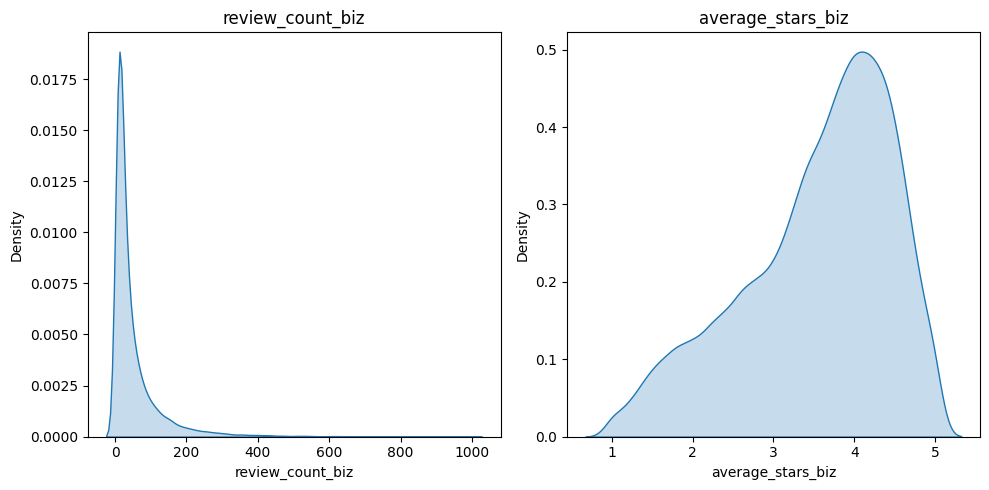

In [ ]:
business_num = business[(business['review_count_biz']>=5) &(business['review_count_biz']<=1000) ].loc[:,'review_count_biz':'average_stars_biz']
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
ax = axes.ravel()

for i, axi in enumerate(ax):
    sns.kdeplot(business_num[business_num.columns[i]], ax=axi, fill=True)
    axi.set_title(business_num.columns[i])
    axi.set_ylabel('Density')

fig.tight_layout()
plt.show()

* 원본 데이터셋 : 상하위 구간 이상치 제거

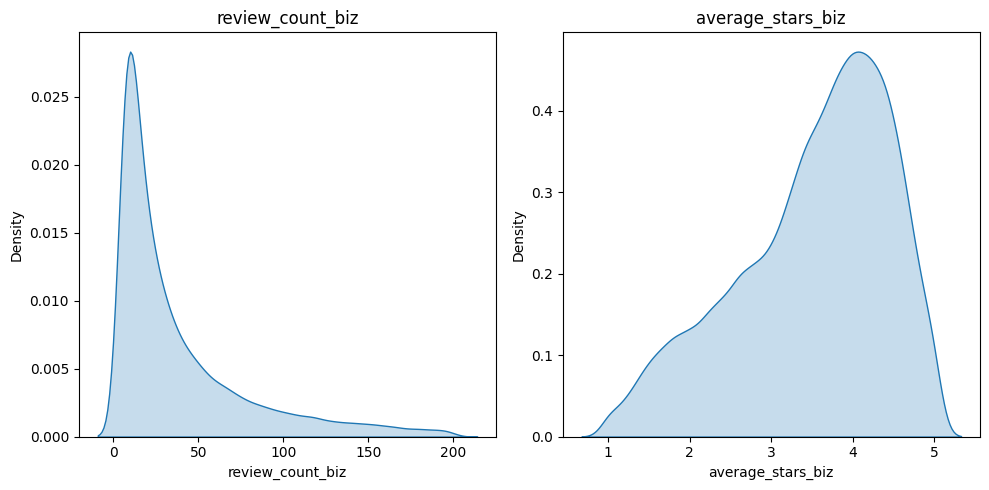

In [ ]:
# 5~200개까지 제한
business_num = business[(business['review_count_biz']>=5) &(business['review_count_biz']<=200)].loc[:,'review_count_biz':'average_stars_biz']
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
ax = axes.ravel()

for i, axi in enumerate(ax):
    sns.kdeplot(business_num[business_num.columns[i]], ax=axi, fill=True)
    axi.set_title(business_num.columns[i])
    axi.set_ylabel('Density')

fig.tight_layout()
plt.show()

### Functions

In [ ]:
# 분포 확인(df 1개)
def counts(df1, var1):
  c1 = df1[var1].value_counts(dropna=False)
  p1 = df1[var1].value_counts(dropna=False, normalize=True)
  return pd.concat([c1,p1], axis=1, keys=['count', '%'])

# 샘플링 전후 분포 비교(df 2개)
def counts_compare(df1, var1, df2, var2):
  c1 = df1[var1].value_counts(dropna=False)
  p1 = df1[var1].value_counts(dropna=False, normalize=True)
  c2 = df2[var2].value_counts(dropna=False)
  p2 = df2[var2].value_counts(dropna=False, normalize=True)
  return pd.concat([c1,p1,c2,p2], axis=1, keys=['origin_df_count', '%','sample_df_count','%'])

In [ ]:
# 0.5점 단위로 구간화하는 함수
def bin_ratings(rating):
    return round(rating * 2) / 2

# 샘플링 함수(비율로 지정)
def sample_stratified_frac(df, frac, variable):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=frac, random_state=42)
    for train_index, test_index in splitter.split(df, df[variable]):
        sampled_df = df.iloc[test_index]
    return sampled_df

### 1st Sampling
* 이상치 제거한 데이터셋에서 평점 분포를 살려 샘플링 시도
* 평점이 좋은 가게와 나쁜 가게들의 비율은 원본과 동일하게 가져가기 위함

In [ ]:
# 이상치 필터
business_filtered = business[(business['review_count_biz']>=5) &(business['review_count_biz']<=200)]
len(business_num)

44765

In [ ]:
# 평점 구간화
business_filtered['bined_stars'] = business_filtered['average_stars_biz'].apply(bin_ratings)

In [ ]:
# 1차 샘플링
business_sample = sample_stratified_frac(business_filtered, 0.1, 'bined_stars')  # 원본의 10%
business_sample

,business_id,name,address,city,state,postal_code,latitude,longitude,is_open,attributes,category,region,review_count_biz,average_stars_biz,bined_stars
5356,54170,Burger King,1301 E Chain Of Rocks Rd,Pontoon Beach,IL,62040,38.761623,-90.065956,1,NaN,"['Restaurants', 'Fast Food']","Pontoon Beach, 62040",8.0,1.625000,1.5
20246,38148,Fito's Taco Shop,13303 E Colossal Cave Rd,Vail,AZ,85641,32.045011,-110.714533,1,NaN,"['Restaurants', 'Mexican']","Vail, 85641",49.0,3.408163,3.5
1948,99096,Bistro La Bête,1703 South 9th St,Philadelphia,PA,19148,39.928004,-75.160045,0,NaN,"['Restaurants', 'French']","Philadelphia, 19148",15.0,5.000000,5.0
21587,77952,Jack in the Box,500 S Illinois St,Belleville,IL,62220,38.508554,-89.983947,0,NaN,"['Restaurants', 'Burgers']","Belleville, 62220",8.0,1.625000,1.5
28159,149162,Jose Mexican Grill,"2000 Mallory Ln, Ste 310",Franklin,TN,37067,35.948851,-86.816085,0,NaN,"['Restaurants', 'Mexican']","Franklin, 37067",30.0,2.900000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21612,27241,Anita Street Market,849 Anita Ave,Tucson,AZ,85705,32.232980,-110.981042,1,NaN,"['Food', 'Grocery']","Tucson, 85705",100.0,4.260000,4.5
5143,18538,Domino's Pizza,1211 N. Madison Ave,Greenwood,IN,46142,39.631254,-86.113844,1,NaN,"['Restaurants', 'Pizza']","Greenwood, 46142",12.0,3.666667,3.5
17486,137061,Greenroots Cafe,1000 Channelside Dr,Tampa,FL,33602,27.948919,-82.445867,0,NaN,"['Restaurants', 'Salad']","Tampa, 33602",21.0,3.952381,4.0
29724,66227,Banh Mi House,13709 N Dale Mabry Hwy,Tampa,FL,33618,28.070535,-82.505622,0,NaN,"['Restaurants', 'Vietnamese']","Tampa, 33618",109.0,4.366972,4.5


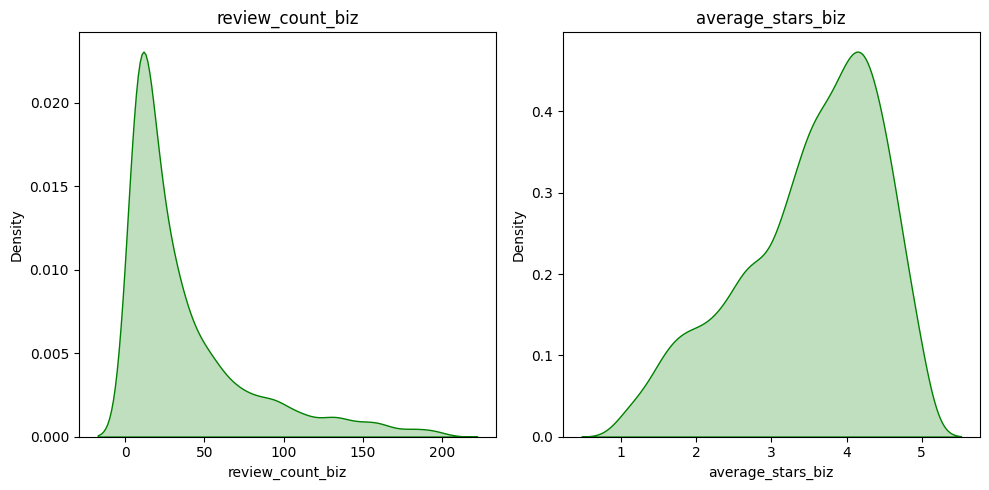

In [ ]:
# 1차 샘플링 후 시각화
business_sample = business_sample.reset_index()
business_sample_viz = business_sample.loc[:,'review_count_biz':'bined_stars']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
ax = axes.ravel()

for i, axi in enumerate(ax):
  sns.kdeplot(business_sample_viz[business_sample_viz.columns[i]], ax=axi, fill=True, color = 'green')
  axi.set_title(business_sample_viz.columns[i])
  axi.set_ylabel('Density')

fig.tight_layout()
plt.show()

In [ ]:
# 필요 시 저장
business_sample.to_csv(file_path + '/file_naem.csv', index=False)

### 2nd Sampling
* 2차 샘플링에선 샘플링한 데이터셋의 리뷰 분포를 일부 조정하여 샘플링하고자 함
  * ≤25개 : 최빈 구간(고밀도 구간)으로, 랜덤 샘플링으로 분포 완화
  * ≥25개 : 상대적으로 밀도가 낮은 구간은 분포를 살려 Stratified Sampling

In [ ]:
# 필요 시 로드
business_sample = pd.read_csv(file_path + '/file_name.csv')

In [ ]:
# 리뷰 수 구간화
n = 10
bins = [ 5+(i*200/n) for i in range(n)] + [200]
business_sample['review_count_bin'] = pd.cut(business_sample['review_count_biz'], bins=bins, include_lowest=True)
counts(business_sample, 'review_count_bin') # 분포 확인

<ipython-input-48-2bd7a1117fc4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  business_sample['review_count_bin'] = pd.cut(business_sample['review_count_biz'], bins=bins, include_lowest=True)


,count,%
review_count_bin,,
"(4.999, 25.0]",2447,0.546571
"(25.0, 45.0]",797,0.178021
"(45.0, 65.0]",426,0.095153
"(65.0, 85.0]",254,0.056734
"(85.0, 105.0]",185,0.041322
"(105.0, 125.0]",115,0.025687
"(125.0, 145.0]",103,0.023006
"(145.0, 165.0]",78,0.017422
"(165.0, 185.0]",43,0.009605


* 고밀도 구간 제외한 나머지 구간

In [ ]:
# 고밀도 제외한 구간
business_sample_bins = business_sample[(business_sample['review_count_biz'] > 25) & (business_sample['review_count_biz'] <= 200)]
print("sample의 크기:",len(business_sample_bins))                           # business 수
print("sample의 review수:",business_sample_bins["review_count_biz"].sum())  # review 수

sample의 크기: 2030
sample의 review수: 139314.0


In [ ]:
# 구간별 분포 맞춰 샘플링(20%)
bins_sample = sample_stratified_frac(business_sample_bins, 0.2,'review_count_bin')
print("sample의 크기:",len(bins_sample))                          # business 수
print("sample의 review수:",bins_sample["review_count_biz"].sum()) # review 수

sample의 크기: 406
sample의 review수: 27902.0


* 고밀도 구간은 random sampling

In [ ]:
# 고밀도 구간
business_sample_highbin = business_sample[(business_sample['review_count_biz'] <= 25) ]
print("sample의 크기:",len(business_sample_highbin))                           # business 수
print("sample의 review수:",business_sample_highbin["review_count_biz"].sum())  # review 수

sample의 크기: 2447
sample의 review수: 30275.0


In [ ]:
highbin_sample = business_sample_highden.sample(frac=0.1, random_state=42)
print("sample의 크기:",len(highbin_sample))                           # business 수
print("sample의 review수:",highbin_sample["review_count_biz"].sum())  # review 수

sample의 크기: 245
sample의 review수: 2978.0


* 두 df 합치기

In [ ]:
# 두 df 합치기
business_sample_final = pd.concat([bins_sample, highbin_sample])
print("sample의 크기:",len(business_sample_final))                          # business 수
print("sample의 review수:",business_sample_final["review_count_biz"].sum()) # review 수

sample의 크기: 651
sample의 review수: 30880.0


In [ ]:
business_sample_final.columns  # 최종 컬럼

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'is_open', 'attributes', 'category', 'region',
       'review_count_biz', 'average_stars_biz', 'bined_stars',
       'review_count_bin'],
      dtype='object')

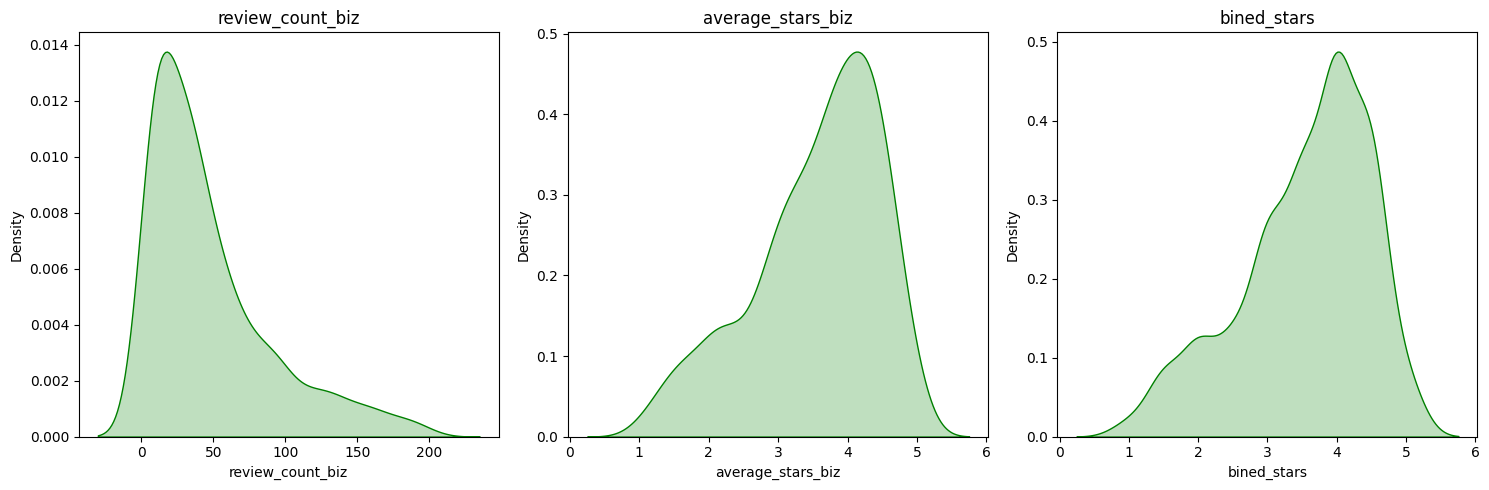

In [ ]:
# 최종 샘플링 파일의 분포 확인
viz = business_sample_final.loc[:,'review_count_biz':'bined_stars']
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
ax = axes.ravel()

for i, axi in enumerate(ax):
  sns.kdeplot(viz[viz.columns[i]], ax=axi, fill=True, color = 'green')
  axi.set_title(viz.columns[i])
  axi.set_ylabel('Density')

fig.tight_layout()
plt.show()

### Compare Distribution

In [ ]:
# 평점 분포 비교
counts_compare(business_sample,'bined_stars', business_sample_final, 'bined_stars')

,origin_df_count,%,sample_df_count,%
bined_stars,,,,
4.0,1069,0.238776,166,0.254992
4.5,838,0.187179,134,0.205837
3.5,811,0.181148,113,0.173579
3.0,559,0.124860,91,0.139785
2.5,397,0.088675,42,0.064516
2.0,314,0.070136,42,0.064516
5.0,241,0.053831,27,0.041475
1.5,193,0.043109,29,0.044547
1.0,55,0.012285,7,0.010753


In [ ]:
# 리뷰 수 분포 비교
counts_compare(business_sample,'review_count_bin', business_sample_final, 'review_count_bin')

,origin_df_count,%,sample_df_count,%
review_count_bin,,,,
"(4.999, 25.0]",2447,0.546571,245,0.376344
"(25.0, 45.0]",797,0.178021,159,0.244240
"(45.0, 65.0]",426,0.095153,85,0.130568
"(65.0, 85.0]",254,0.056734,51,0.078341
"(85.0, 105.0]",185,0.041322,37,0.056836
"(105.0, 125.0]",115,0.025687,23,0.035330
"(125.0, 145.0]",103,0.023006,20,0.030722
"(145.0, 165.0]",78,0.017422,16,0.024578
"(165.0, 185.0]",43,0.009605,9,0.013825


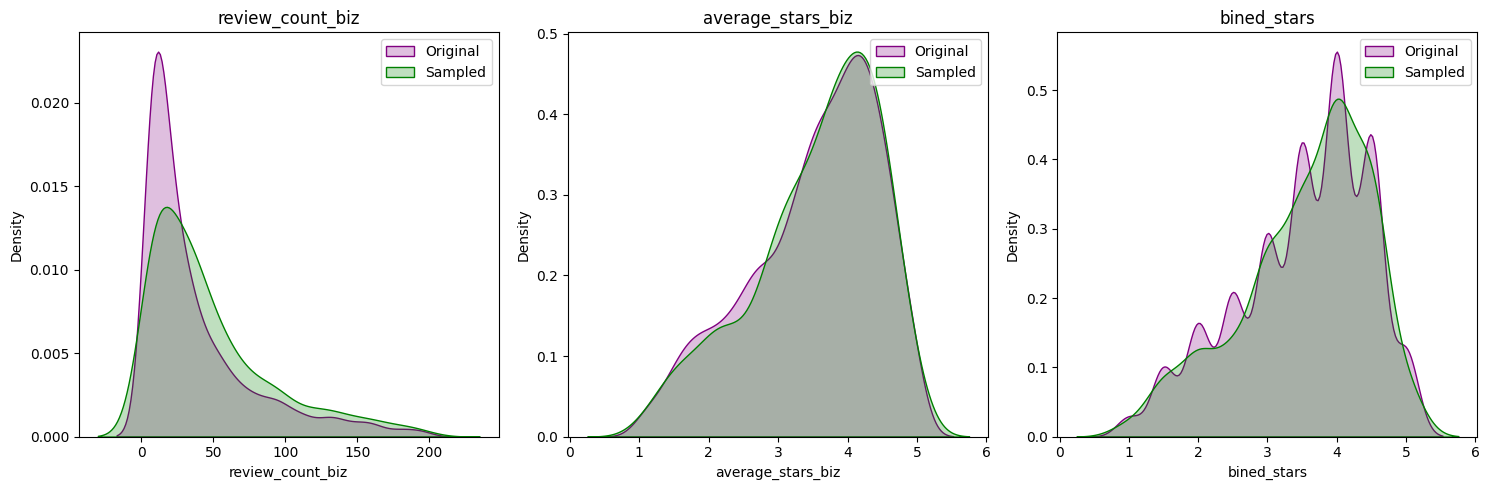

In [ ]:
# 분포 비교 시각화
temp = business_sample_final.loc[:, 'review_count_biz':'bined_stars']
original_temp = business_sample.loc[:, 'review_count_biz':'bined_stars']

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
ax = axes.ravel()

colors = ['purple', 'green']
labels = ['Sampled', 'Original']

for i, axi in enumerate(ax):
  sns.kdeplot(original_temp[original_temp.columns[i]], ax=axi, fill=True, color=colors[0], label=labels[1])
  sns.kdeplot(temp[temp.columns[i]], ax=axi, fill=True, color=colors[1], label=labels[0])
  axi.set_title(temp.columns[i])
  axi.set_ylabel('Density')
  axi.legend()

fig.tight_layout()
plt.show()

In [ ]:
# 저장
business_sample_final.to_csv(file_path + '/file_naem.csv', index=False)

## review filtering
* 앞서 수행한 business 샘플링 데이터셋에서 business_id와 매칭하여 review 데이터셋 필터링

In [ ]:
# 전처리된 데이터셋
review = pd.read_csv(file_path + '/file_name.csv')
# business_sample_final = pd.read_csv(file_path + '/file_name.csv') # 필요 시 로드

In [ ]:
biz_ids = business_sample_final['business_id'].to_list()
review_sample = review[review['business_id'].isin(biz_ids)]
review_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30880 entries, 184 to 2680029
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   review_id    30880 non-null  int64  
 1   user_id      30880 non-null  int64  
 2   business_id  30880 non-null  int64  
 3   stars        30880 non-null  float64
 4   useful       30880 non-null  int64  
 5   funny        30880 non-null  int64  
 6   cool         30880 non-null  int64  
 7   text         30880 non-null  object 
 8   date         30880 non-null  object 
 9   text_length  30880 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 2.6+ MB


In [ ]:
# 저장
review_sample.to_csv(file_path + '/file_naem.csv', index=False)